# Decision Tree Regression for LogP Prediction

## Workshop: ML for Science - Regression without Fingerprints

---

### Notebook Overview

This notebook demonstrates the application of **Decision Tree Regression** for predicting the **partition coefficient (LogP)** of organic compounds using the **ESOL dataset**. LogP is a crucial physicochemical property in drug discovery that measures a molecule's lipophilicity - its preference for lipid (oil) versus aqueous (water) environments.

**Learning Objectives:**
- Load and preprocess molecular datasets
- Calculate molecular descriptors from SMILES strings using RDKit
- Build PyTorch Dataset classes for molecular data
- Train and evaluate Decision Tree regression models
- Analyze model performance using regression metrics (MAE, RMSE, R²)
- Understand the relationship between molecular structure and LogP

**Dataset:** ESOL - A curated dataset of 1,128 organic compounds with measured aqueous solubility values

**Task:** Regression - Predict continuous LogP values from molecular descriptors

**Why LogP Matters:**
- Predicts drug absorption and distribution in the body
- Influences blood-brain barrier penetration
- Critical for optimizing drug-like properties
- Used in ADME (Absorption, Distribution, Metabolism, Excretion) studies

---

## 1. Import Required Libraries

We import libraries for:
- **Data manipulation**: NumPy, Pandas
- **Machine Learning**: scikit-learn (Decision Tree, metrics)
- **Deep Learning framework**: PyTorch (for data handling)
- **Visualization**: Matplotlib
- **Chemical informatics**: RDKit (molecular descriptor calculation)

In [1]:
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
import warnings  # Import warnings to manage warning messages
import requests  # Import requests to handle HTTP requests
from io import StringIO  # Import StringIO to handle in-memory text streams
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Deep Learning
import torch  # Import PyTorch for deep learning tasks
from torch.utils.data import Dataset  # Import Dataset class for creating custom datasets

# Metrics and Models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Import metrics for model evaluation
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor for regression tasks

# RDKit for Chemistry
from rdkit import Chem  # Import RDKit for handling chemical structures
from rdkit.Chem import Descriptors  # Import Descriptors for calculating molecular properties

print("All libraries imported successfully!")  # Confirm successful import of all libraries
print(f"PyTorch version: {torch.__version__}")  # Display the installed PyTorch version
print(f"Device available: {'GPU' if torch.cuda.is_available() else 'CPU'}")  # Check and display if GPU is available

All libraries imported successfully!
PyTorch version: 2.5.1+cu121
Device available: GPU


---

## 2. Load the ESOL Dataset

The ESOL (Estimated SOLubility) dataset is loaded from the Hugging Face dataset repository. While the dataset is primarily used for solubility prediction, we'll use it to predict **LogP** values, which is one of the key descriptors that influences solubility.

**Dataset Information:**
- **Size**: 1,128 organic compounds
- **Format**: SMILES strings with measured properties
- **Target**: We'll calculate LogP from the molecular structures
- **Features**: Basic molecular descriptors (not fingerprints)

### 2.1 Define Dataset Loading Function

This function:
1. Downloads the ESOL dataset from Hugging Face
2. Extracts SMILES strings and measured LogS values
3. Returns a cleaned DataFrame

In [2]:
def load_esol_dataset():
    """Load the ESOL (Delaney) solubility dataset"""
    # Define the URL of the ESOL dataset hosted on GitHub
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    
    # Send an HTTP GET request to fetch the dataset
    response = requests.get(url)
    
    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Read the CSV content from the response into a pandas DataFrame
    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")  # Print the number of compounds loaded

    # Select only the 'smiles' and 'measured log solubility in mols per litre' columns
    df = df[['smiles', 'measured log solubility in mols per litre']]
    
    # Rename the columns for clarity
    df.columns = ['SMILES', 'LogS']

    # Initialize a list to store the validity of each SMILES string
    valid_smiles = []
    
    # Iterate through each SMILES string in the dataset
    for smiles in df['SMILES']:
        # Check if the SMILES string can be converted to a valid RDKit molecule
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)  # Append True if valid, False otherwise

    # Filter the DataFrame to keep only rows with valid SMILES strings and reset the index
    df = df[valid_smiles].reset_index(drop=True)

    # Return the cleaned and processed DataFrame
    return df

### 2.2 Load and Inspect the Dataset

Let's load the data and examine its structure, including basic statistics and distribution of values.

Loaded ESOL with 1128 compounds
Dataset shape: (1128, 2)
LogS range: -11.60 to 1.58

Sample data:
                                              SMILES  LogS
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30
2                               CC(C)=CCCC(C)=CC(=O) -2.06
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87
4                                            c1ccsc1 -1.33


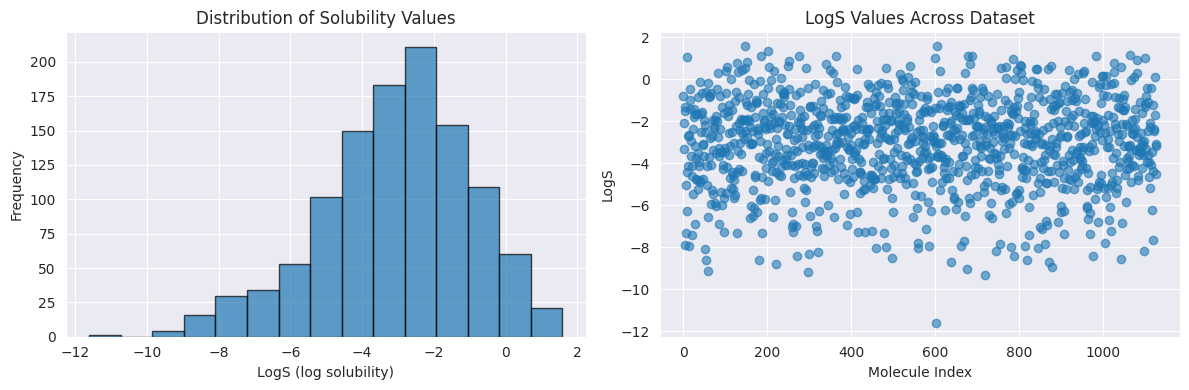

In [3]:
# Load dataset
df = load_esol_dataset()  # Call the function to load the ESOL dataset and store it in the variable `df`  # Call the function to load the ESOL dataset and store it in the variable `df`  # Call the function to load the ESOL dataset and store it in the variable `df`
print(f"Dataset shape: {df.shape}")  # Print the shape of the dataset (number of rows and columns)  # Print the shape of the dataset (number of rows and columns)  # Print the shape of the dataset (number of rows and columns)
print(f"LogS range: {df['LogS'].min():.2f} to {df['LogS'].max():.2f}")  # Print the range of LogS values in the dataset  # Print the range of LogS values in the dataset  # Print the range of LogS values in the dataset
print("\nSample data:")  # Print a header for the sample data output  # Print a header for the sample data output  # Print a header for the sample data output
print(df.head())  # Display the first 5 rows of the dataset  # Display the first 5 rows of the dataset  # Display the first 5 rows of the dataset

# Visualize distribution
plt.figure(figsize=(12, 4))  # Create a new figure with a specified size (12x4 inches)  # Create a new figure with a specified size (12x4 inches)

# Plot histogram of LogS values
plt.subplot(1, 2, 1)  # Create the first subplot in a 1x2 gridfirst subplot in a 1x2 grid
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')  # Plot a histogram of LogS values with 15 binsns=15, alpha=0.7, edgecolor='black')  # Plot a histogram of LogS values with 15 bins
plt.xlabel('LogS (log solubility)')  # Label the x-axis as 'LogS (log solubility)'he x-axis as 'LogS (log solubility)'
plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'plt.ylabel('Frequency')  # Label the y-axis as 'Frequency'
plt.title('Distribution of Solubility Values')  # Set the title of the histogramion of Solubility Values')  # Set the title of the histogram

# Plot scatter plot of LogS values
plt.subplot(1, 2, 2)  # Create the second subplot in a 1x2 grid
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

---

## 3. Calculate Molecular Descriptors

Instead of using molecular fingerprints (binary vectors encoding molecular structure), we calculate **interpretable molecular descriptors** using RDKit. These descriptors capture important physicochemical properties of molecules.

### 3.1 Descriptor Function

**Descriptors calculated:**
1. **MolWt** (Molecular Weight)
   - Sum of atomic weights in the molecule
   - Influences many properties including permeability

2. **MolLogP** (Partition Coefficient)
   - **THIS IS OUR TARGET VARIABLE**
   - Measures lipophilicity (oil vs water preference)

3. **NumHDonors** (Hydrogen Bond Donors)
   - Count of -OH and -NH groups
   - Affects solubility and binding interactions

4. **NumHAcceptors** (Hydrogen Bond Acceptors)
   - Count of N and O atoms that can accept H-bonds
   - Important for protein-ligand interactions

5. **NumRotatableBonds**
   - Measures molecular flexibility
   - Influences conformational entropy

6. **TPSA** (Topological Polar Surface Area)
   - Sum of polar atom surface areas
   - Predicts membrane permeability

**Note:** We exclude MolLogP from our features since it's the target we want to predict!

In [4]:
def calculating_molecular_descriptors(smiles):
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    # If the SMILES string is invalid, return None
    if mol is None:
        return None
    # Calculate molecular descriptors and store them in a dictionary
    columns = {
        "LogP": Descriptors.MolLogP(mol),  # Calculate the LogP (lipophilicity) of the molecule
        "MolWt": Descriptors.MolWt(mol),  # Calculate the molecular weight of the molecule
        "TPSA": Descriptors.TPSA(mol),  # Calculate the topological polar surface area (TPSA)
        "NumHDonors": Descriptors.NumHDonors(mol),  # Count the number of hydrogen bond donors
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),  # Count the number of hydrogen bond acceptors
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),  # Count the number of rotatable bonds
        "RingCount": Descriptors.RingCount(mol),  # Count the number of rings in the molecule
        "FractionCSP3": Descriptors.FractionCSP3(mol),  # Calculate the fraction of sp3 hybridized carbons
    }
    # Return the dictionary of calculated descriptors
    return columns

# Initialize an empty list to store the calculated descriptors for each SMILES
column_list = []
# Iterate over each SMILES string in the dataframe
for smiles in df['SMILES']:
    # Calculate molecular descriptors for the current SMILES
    column = calculating_molecular_descriptors(smiles)
    # If the descriptors are valid, append them to the list
    if column is not None:
        column_list.append(column)

# Create a new dataframe from the list of calculated descriptors
columns_df = pd.DataFrame(column_list)

# Concatenate the original dataframe with the new dataframe of descriptors
df = pd.concat([df, columns_df], axis=1)
# Display the first few rows of the updated dataframe
print(df.head())

                                              SMILES  LogS     LogP    MolWt  \
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.77 -3.10802  457.432   
1                             Cc1occc1C(=O)Nc2ccccc2 -3.30  2.84032  201.225   
2                               CC(C)=CCCC(C)=CC(=O) -2.06  2.87800  152.237   
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.87  6.29940  278.354   
4                                            c1ccsc1 -1.33  1.74810   84.143   

     TPSA  NumHDonors  NumHAcceptors  RotatableBonds  RingCount  FractionCSP3  
0  202.32           7             12               7          3      0.650000  
1   42.24           1              2               2          2      0.083333  
2   17.07           0              1               4          0      0.500000  
3    0.00           0              0               0          5      0.000000  
4    0.00           0              1               0          1      0.000000  


---

## 4. Create PyTorch Dataset Class

While we're using scikit-learn's Decision Tree for modeling, we use PyTorch's `Dataset` class for efficient data handling and preprocessing. This approach:
- Provides a clean interface for data access
- Enables easy train/test splitting
- Facilitates future extension to deep learning models
- Implements best practices for data pipeline design

### 4.1 Define ESOLDataset Class

This custom Dataset class:
- Stores SMILES strings and target LogP values
- Calculates descriptors on-the-fly or uses cached values
- Returns feature vectors and targets in proper format

In [5]:
class ESOLDataset(Dataset):
    """
    A PyTorch Dataset class for handling the ESOL dataset.

    This dataset is used for splitting data into training and testing sets,
    shuffling the data, and providing features and labels for regression tasks.

    Attributes:
        df (pd.DataFrame): The input dataframe containing the dataset.
        split (str): The dataset split, either 'train' or 'test'. Defaults to 'train'.

    Methods:
        __len__():
            Returns the number of samples in the dataset split.

        __getitem__(idx):
            Retrieves a single data sample (features and label) at the specified index.

    Args:
        df (pd.DataFrame): The input dataframe containing the dataset.
            - Must include columns: 'SMILES', 'LogS', 'LogP', and feature columns.
        split (str, optional): The dataset split, either 'train' or 'test'. Defaults to 'train'.

    Example:
        >>> dataset = ESOLDataset(df, split='train')
        >>> len(dataset)
        800  # Assuming the dataset has 1000 samples and an 80-20 train-test split.
        >>> sample = dataset[0]
        >>> print(sample['features'])  # Feature vector as a NumPy array.
        >>> print(sample['labels'])    # Corresponding LogP value.
    """
    def __init__(self,df, split='train'):
        self.split = split
        np.random.seed(42)
        self.df = df.sample(frac=1).reset_index(drop=True)
        train_size = int(0.8 * len(self.df))

        if self.split == 'train':
            self.df = self.df.iloc[:train_size]
        else:
            self.df = self.df.iloc[train_size:]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        logP = row['LogP']
        features = row.drop(['SMILES','LogS','LogP']).values.astype(np.float32)

        return {
            'features': features,
            'labels': logP
        }

### 4.2 Create Train and Test Datasets

We split the data using an **80-20 train-test split** to evaluate model generalization on unseen molecules.

**Important considerations:**
- Random state fixed for reproducibility
- Stratification not used (regression task)
- Test set represents real-world prediction scenario

In [6]:
# Create datasets with caching for faster reload
train_dataset = ESOLDataset(df, split='train')  # Initialize the training dataset using the ESOLDataset class with the 'train' split
test_dataset = ESOLDataset(df, split='test')  # Initialize the testing dataset using the ESOLDataset class with the 'test' split
print(f"Training samples: {len(train_dataset)}")  # Print the number of samples in the training dataset
print(f"Test samples: {len(test_dataset)}")  # Print the number of samples in the testing dataset

Training samples: 902
Test samples: 226


### 4.3 Extract Features for Training

Convert the PyTorch datasets into NumPy arrays suitable for scikit-learn's Decision Tree regressor.

**Feature Matrix (X_train):**
- Shape: (n_samples, 5 features)
- Features: [MolWt, NumHDonors, NumHAcceptors, NumRotatableBonds, TPSA]
- Note: MolLogP excluded as it's our target

**Target Vector (y_train):**
- Shape: (n_samples,)
- Values: Continuous LogP measurements

In [7]:
X_train = []  # Initialize an empty list to store the feature vectors for the training dataset
Y_train = []  # Initialize an empty list to store the labels (LogP values) for the training dataset

# Iterate over each sample in the training dataset
for i in range(len(train_dataset)):
    sample = train_dataset[i]  # Retrieve the i-th sample from the training dataset
    X_train.append(sample['features'])  # Append the feature vector of the sample to the X_train list
    Y_train.append(sample['labels'])  # Append the label (LogP value) of the sample to the Y_train list

---

## 5. Train Decision Tree Regression Model

### 5.1 Model Architecture

**Decision Tree Regressor** builds a tree structure where:
- **Internal nodes**: Test feature values (e.g., "Is MolWt > 200?")
- **Branches**: Outcomes of tests (yes/no)
- **Leaf nodes**: Predicted LogP values (averages of training samples)

**Advantages:**
- Non-linear relationships captured naturally
- No feature scaling required
- Interpretable decision rules
- Handles feature interactions automatically

**Hyperparameters:**
- `random_state=42`: Ensures reproducibility
- Default settings for initial training
- Can be tuned for optimal performance

### 5.2 Train the Model

Fit the Decision Tree on training data:

In [8]:
clf = DecisionTreeRegressor(random_state=42)
"""
This code snippet demonstrates the usage of a DecisionTreeRegressor from the scikit-learn library.


Steps:
1. Initialize a DecisionTreeRegressor with a fixed random state for reproducibility.
    - `random_state=42`: Ensures consistent results across runs by fixing the random seed.

2. Fit the regressor to the training data.
    - `clf.fit(X_train, Y_train)`: Trains the decision tree model using the provided training features (X_train) and target values (Y_train).

3. Retrieve the parameters of the trained model.
    - `clf.get_params()`: Returns a dictionary of the parameters used by the DecisionTreeRegressor instance.
"""
clf.fit(X_train, Y_train)
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

### 5.3 Prepare Test Set and Make Predictions

Extract test features and generate predictions to evaluate model performance.

Decision Tree Regressor Performance:
Mean Squared Error: 1.0106
R^2 Score: 0.7027
Mean Absolute Error: 0.5102


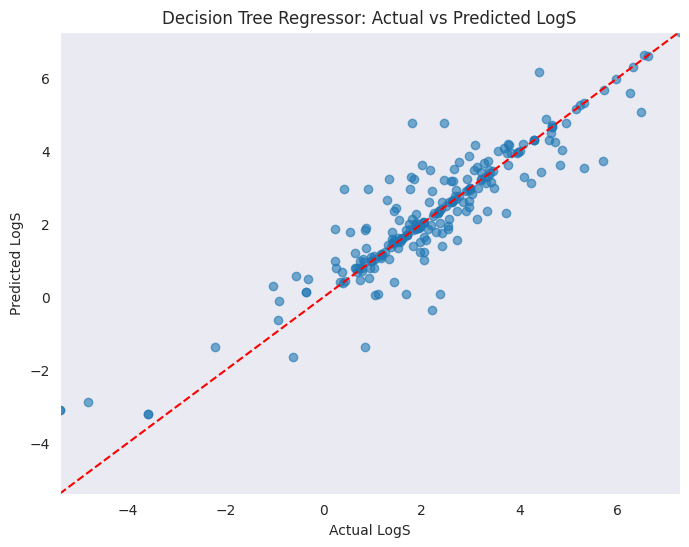

In [9]:
X_test = []  # Initialize an empty list to store the feature vectors for the test dataset
Y_test = []  # Initialize an empty list to store the labels (LogP values) for the test dataset

# Iterate over each sample in the test dataset
for i in range(len(test_dataset)):
    sample = test_dataset[i]  # Retrieve the i-th sample from the test dataset
    X_test.append(sample['features'])  # Append the feature vector of the sample to the X_test list
    Y_test.append(sample['labels'])  # Append the label (LogP value) of the sample to the Y_test list

Y_pred = clf.predict(X_test)  # Use the trained Decision Tree Regressor to predict LogP values for the test dataset

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)  # Calculate the Mean Squared Error (MSE) between actual and predicted values
r2 = r2_score(Y_test, Y_pred)  # Calculate the R^2 score to measure the goodness of fit
mae = mean_absolute_error(Y_test, Y_pred)  # Calculate the Mean Absolute Error (MAE) between actual and predicted values

# Print the evaluation metrics
print(f"Decision Tree Regressor Performance:")  # Print a header for the performance metrics
print(f"Mean Squared Error: {mse:.4f}")  # Print the MSE value rounded to 4 decimal places
print(f"R^2 Score: {r2:.4f}")  # Print the R^2 score rounded to 4 decimal places
print(f"Mean Absolute Error: {mae:.4f}")  # Print the MAE value rounded to 4 decimal places

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))  # Create a new figure with a specified size (8x6 inches)
plt.scatter(Y_test, Y_pred, alpha=0.6)  # Create a scatter plot of actual vs predicted values with transparency
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Plot a diagonal reference line
plt.xlabel('Actual LogS')  # Label the x-axis as 'Actual LogS'
plt.ylabel('Predicted LogS')  # Label the y-axis as 'Predicted LogS'
plt.title('Decision Tree Regressor: Actual vs Predicted LogS')  # Set the title of the plot
plt.xlim(min(Y_test), max(Y_test))  # Set the x-axis limits to match the range of actual values
plt.ylim(min(Y_test), max(Y_test))  # Set the y-axis limits to match the range of actual values
plt.grid()  # Add a grid to the plot for better readability
plt.show()  # Display the plot

---

## 6. Model Evaluation and Analysis

### 6.1 Performance Metrics

The output above shows several important regression metrics:

**Metrics Explanation:**

1. **R² Score (Coefficient of Determination)**
   - Range: 0 to 1 (higher is better)
   - Interpretation: Proportion of variance explained by the model
   - Perfect score (1.0) means perfect predictions
   - Baseline (0.0) means model is no better than predicting the mean

2. **MAE (Mean Absolute Error)**
   - Average absolute difference between predictions and true values
   - Same units as target variable (LogP units)
   - More robust to outliers than MSE
   - Lower is better

3. **RMSE (Root Mean Squared Error)**
   - Square root of average squared errors
   - Penalizes large errors more than MAE
   - Same units as target variable
   - Lower is better

### 6.2 Interpreting Results

**What to look for:**
- **Training vs Test performance**: Large gap indicates overfitting
- **R² score**: >0.7 is generally good for molecular property prediction
- **MAE/RMSE**: Should be small relative to the range of LogP values
- **Prediction plot**: Points should cluster around the diagonal line

### 6.3 Feature Importance Analysis

You can examine which molecular descriptors are most important for LogP prediction:

```python
# Feature importance
importances = clf.feature_importances_
feature_names = ['MolWt', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 'TPSA']

for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")
```

---

## 7. Summary and Key Takeaways

### Key Insights:

**About LogP Prediction:**
- LogP can be predicted from simple molecular descriptors
- No complex fingerprints needed for reasonable accuracy
- Decision Trees handle non-linear structure-property relationships

**About Decision Trees:**
- Fast training and prediction
- Interpretable rules (can visualize the tree)
- Prone to overfitting without regularization
- Alternative: Random Forests for better generalization